<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>



## Subsurface Facies Prediction using K Nearest Neighbors

#### Divya Shah
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin


_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)






### Executive Summary

#### What is the gap, problem, opportunity, scientific question?

* Subsurface Facies classification is extremely important for predicting potential reservoirs for hydrocarbon extraction and with the current accelerating energy transition also for geologic carbon dioxide and hydrogen storage. There is also a need to identify potential seals/cap-rocks to ensure safe trapping.

#### What was done to address the above?

* We have used a dataset with well-log responses and subsurface rock facies corresponding to the log responses. We followed the usual Machine Learning response to train the model parameters, tune the model hyperparameters and then tested the model on a blind dataset to see the facies prediction from the KNN Model as compared to the actual facies.

#### What was learned?

* We learned on how the model classifies the facies based on the well-log data. However when we tuned the hyperparameters, we found that the best model performance had more classifiers than the original number of facies in the dataset. Also, as we used KNN to classify the facies, we did not perform feature ranking to see the importance of different features in predicting the response.

#### What are your recommendations?

* Based on the model, I would like to recommend that we compare multiple machine learning methods like Support Vector Machines, Random Forest and also do a feature ranking where we can quantitatively rank the importance of the features in predicting the facies.

### Subsurface Facies Classification using Well Logs

So we follow the usual machine learning workflow in the project. We start with loading the data, data preparation and cleaning, visualizing presence of outliers, scaling the data, performing the train-test split, applying the model on the training data, tuning the model hyperparameters and then applying the model to a blind dataset(Well), and then checking the model goodness metrics like f-1 score, confusion matrix.



### 1. Loading the Data

### 2. Data preparation and Cleaning

### 3. Data Visualization

### 4. Outlier Detection and Removal

### 5. Scaling the Data

### 6. Model Training and Hyperparameter Tuning

### 7. Testing the Model

### Results

The results include the comparison of the predicted facies and original facies. f-1 score and confusion matrices have also been plotted to show the performance of the KNN in predicting the facies. 


### Import Packages

In [2]:
# packages for model checking
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score         # cross validation methods

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display


import os                                                   # to set current working directory 
import math                                                 # basic calculations like square root
from sklearn.neighbors import KNeighborsRegressor           # for nearest k neighbours
from sklearn import metrics                                 # measures to check our models
from sklearn.model_selection import cross_val_score         # cross validation methods
import pandas as pd                                         # DataFrames and plotting
import seaborn as sns                                       # for pairplot
import pandas.plotting as pd_plot
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # plotting
from subprocess import check_call
from sklearn.model_selection import train_test_split        # train and test split
seed = 13013
cmap = plt.cm.inferno                                       # select color map
import warnings
warnings.filterwarnings('ignore')                           # supress warnings

### Plotting functions

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfaceDataAnalytics_KNN.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb).


In [3]:
def plot_corr(dataframe,size=10):                               # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap_temp = plt.cm.inferno
    xplot_step = (x_max-x_min)/100; yplot_step = (y_max-y_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step),
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap_temp,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap_temp, norm=None, vmin=z_min, vmax=z_max, alpha=1.0, linewidths=0.8, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    
def visualize_tuned_model(k_tuned,k_mat,score_mat):
    plt.scatter(k_mat,score_mat,s=10.0, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.5, edgecolors="black")
    plt.plot([k_tuned,k_tuned],[0,10000000],color='black',linestyle=(6, (2,3)),label='tuned',zorder=1)
    plt.title('k-fold Cross Validation Error (MSE) vs. k Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
    plt.xlim(k_min,k_max); plt.ylim(0,np.max(score_mat))
    
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='darkorange',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.8, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

### Load Data

The following workflow applies the .csv file 'SEGData_Project.csv', a dataset with well log responses and facies classification. It is available here.

We will work with the following predictor features:

* **gamma ray log** - Gamma ray logs are used primarily to distinguish clean, potentially productive intervals from probable unproductive shale intervals.

* **Induction Log** - Induction logging was originally developed to measure formation resistivities in boreholes containing oil-based muds and in air-drilled boreholes

* **DeltaPHI (Neutron-Density Porosity Difference and Average Neutron Porosity** - Referring to a log of porosity based on the effect of the formation on fast neutrons emitted by a source. Hydrogen has by far the biggest effect in slowing down and capturing neutrons. Since hydrogen is found mainly in the pore fluids, the neutron porosity log responds principally to porosity. 

* Two geologic constraining variables: **nonmarine/marine indicator (NM_M) and relative position (RELPOS)**


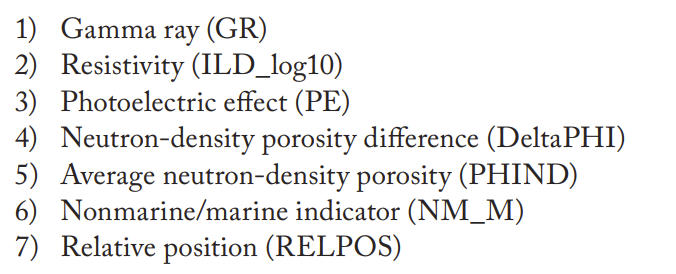


In [4]:
#Load data from the given csv file
#df=pd.read_csv('SEGData_Project.csv',index_col=0) # Importing the data set which is in .csv format
df = pd.read_csv("https://raw.githubusercontent.com/divyashah28/ML_project/main/SEGData_Project.csv", index_col=0)
df

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,3
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3


### Relabeling Facies to New Labels representing Lithology

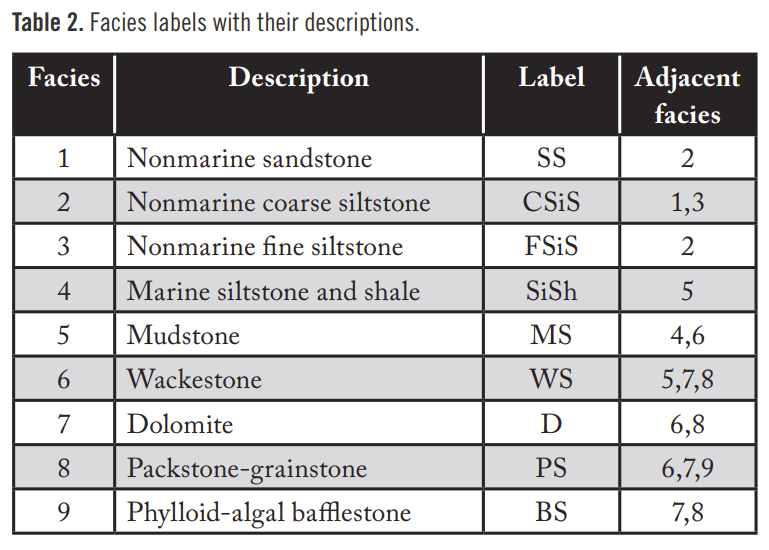

In [5]:
# From the above table we can see that facies are labels from 1 to 9 hence we will relabel them to the new label representing their lithology 
labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS'] 
df['Facies_Label']=np.select([df['Facies'] == 1,df['Facies'] == 2,df['Facies'] == 3,df['Facies'] == 4,df['Facies'] == 5,df['Facies'] == 6,df['Facies'] == 7,df['Facies'] == 8,df['Facies'] == 9,],labels,default='')

### Cleaning up the data. 
Well Name, Formation and Facies_label Columns can be converted into a categorical datatype.

In [6]:
# Cleaning up the data. Well Name, Formation and Facies_label Columns can be converted into a categorical datatype.
df['Well Name'] = df['Well Name'].astype('category')
df['Formation'] = df['Formation'].astype('category')
df['Facies_Label'] = df['Facies_Label'].astype('category')
df['Well Name'].unique()


['STUART', 'CRAWFORD']
Categories (2, object): ['CRAWFORD', 'STUART']

### Displaying the dataset

In [7]:
df

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies,Facies_Label
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3,FSiS
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3,FSiS
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3,FSiS
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3,FSiS
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,3,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3,FSiS
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3,FSiS
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3,FSiS
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3,FSiS


### Visualizing property Variation wth Facies

Creating a scatterplot to visualize variation with Facies. We use seaborn pairplot to show the relationship between two of the variables on the x and y axis, with each point is colored according to its facies.

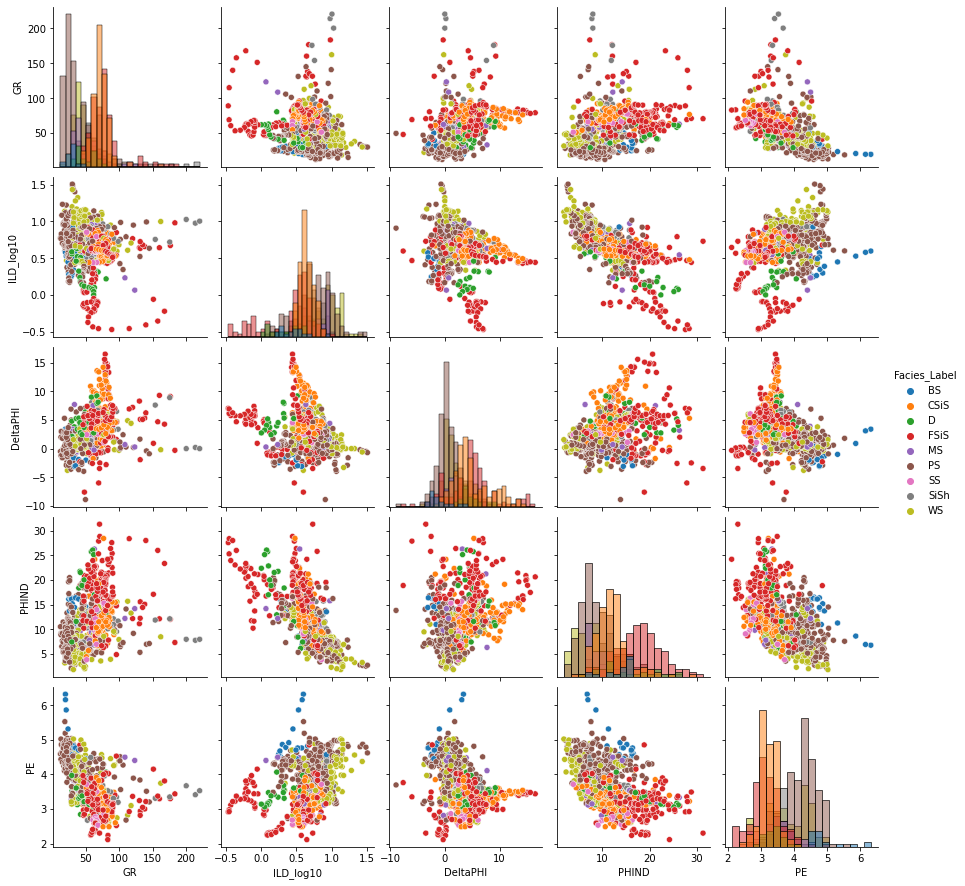

In [18]:
sns.pairplot(df.drop(['Facies','NM_M','RELPOS','Depth'], axis = 1) ,hue='Facies_Label',diag_kind='hist')

### Defining color map for each facies and describing the data


The following code block is from Brendon Hall with the reference stated here.

(https://github.com/seg/tutorials-2016/blob/master/1610_Facies_classification/Facies%20Classification%20-%20SVM.ipynb)


In [8]:
# Before plotting the well data, we are defining a color map so the facies are represented by consistent color in all the plots
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

#facies_color_map is a dictionary that maps facies labels to their respective colors

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
df.loc[:,'Facies_Label'] = df.apply(lambda row: label_facies(row, facies_labels), axis=1)
df.describe().transpose() #quick view of the statistical distribution of the input variables. 

,count,mean,std,min,25%,50%,75%,max
Depth,830.0,2987.070482,94.391925,2808.000,2911.62500,2993.7500,3055.37500,3160.500
GR,830.0,57.611730,27.527740,12.036,36.77325,58.3445,73.05150,220.413
ILD_log10,830.0,0.666312,0.288367,-0.468,0.54100,0.6750,0.85075,1.507
DeltaPHI,830.0,2.851964,3.442074,-8.900,0.41125,2.3975,4.60000,16.500
PHIND,830.0,11.655277,5.190236,1.855,7.70000,10.9500,14.79375,31.335
PE,830.0,3.654178,0.649793,2.113,3.17150,3.5155,4.19150,6.321
NM_M,830.0,1.678313,0.467405,1.000,1.00000,2.0000,2.00000,2.000
RELPOS,830.0,0.535807,0.283062,0.013,0.30000,0.5475,0.77800,1.000
Facies,830.0,4.948193,2.420453,1.000,3.00000,5.0000,8.00000,9.000


### Function for plotting the well logs

The following code block is from Brendon Hall with the reference stated here.

(https://github.com/seg/tutorials-2016/blob/master/1610_Facies_classification/Facies%20Classification%20-%20SVM.ipynb)


In [20]:
# create plots for the five well log variables, as well as a log for facies labels. 

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

### Displaying the well log for the Training Well

We have taken the 'Stuart' Well as the training well and the other well 'Crawford' as the testing well

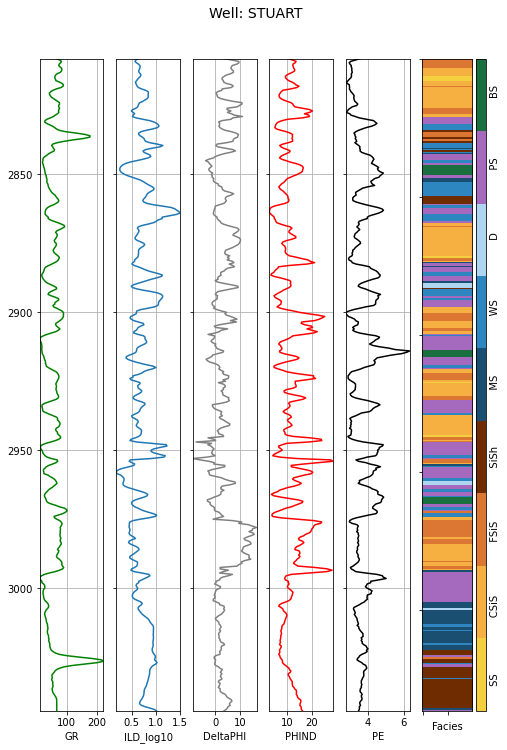

In [21]:
make_facies_log_plot(
    df[df['Well Name'] == 'STUART'], #Since our training well is STUART
    facies_colors)

### Counting Unique Entries for each facies and plotting the facies distribution

SS       20
CSiS    159
FSiS    154
SiSh     65
MS       49
WS      127
D        26
PS      212
BS       18
Name: Facies, dtype: int64

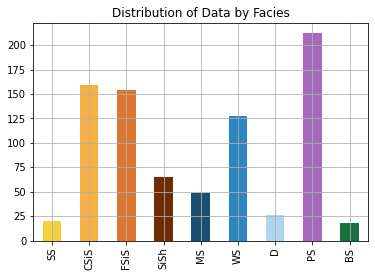

In [22]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = df['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Data by Facies',grid = True,linewidth=0.6)
facies_counts

### Setting the index as the depth

In [23]:
#Set Index Depth
df.set_index('Depth',inplace=True)

### Grouping by well name

In [24]:
#Group by Well Name
df.groupby("Well Name").count()

,Formation,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies,Facies_Label
Well Name,,,,,,,,,,
CRAWFORD,356,356,356,356,356,356,356,356,356,356
STUART,474,474,474,474,474,474,474,474,474,474


### Checking the data to see if there is any missing data

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 830 entries, 2808.0 to 3160.5
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Formation     830 non-null    category
 1   Well Name     830 non-null    category
 2   GR            830 non-null    float64 
 3   ILD_log10     830 non-null    float64 
 4   DeltaPHI      830 non-null    float64 
 5   PHIND         830 non-null    float64 
 6   PE            830 non-null    float64 
 7   NM_M          830 non-null    int64   
 8   RELPOS        830 non-null    float64 
 9   Facies        830 non-null    int64   
 10  Facies_Label  830 non-null    object  
dtypes: category(2), float64(6), int64(2), object(1)
memory usage: 67.2+ KB


### Dropping any 'NaN' if any

In [26]:
df= df.dropna() # We will remove the missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 830 entries, 2808.0 to 3160.5
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Formation     830 non-null    category
 1   Well Name     830 non-null    category
 2   GR            830 non-null    float64 
 3   ILD_log10     830 non-null    float64 
 4   DeltaPHI      830 non-null    float64 
 5   PHIND         830 non-null    float64 
 6   PE            830 non-null    float64 
 7   NM_M          830 non-null    int64   
 8   RELPOS        830 non-null    float64 
 9   Facies        830 non-null    int64   
 10  Facies_Label  830 non-null    object  
dtypes: category(2), float64(6), int64(2), object(1)
memory usage: 67.2+ KB


### Making a hard copy of the Test Well Data

In [10]:
test_well = df[df['Well Name'] == 'CRAWFORD'] #Test Data
df_new = df[df['Well Name'] != 'CRAWFORD'] # Train Data

### Displaying the Training Well Data

In [11]:
df_new

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies,Facies_Label
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,3,FSiS
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,3,FSiS
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,3,FSiS
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,3,FSiS
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,3,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
469,C LM,STUART,3042.5,67.683,0.701,6.0,15.20,3.603,2,0.291,4,SiSh
470,C LM,STUART,3043.0,67.683,0.778,5.1,15.65,3.537,2,0.284,4,SiSh
471,C LM,STUART,3043.5,67.683,0.882,4.9,15.75,3.547,2,0.276,4,SiSh
472,C LM,STUART,3044.0,67.683,0.973,4.4,15.80,3.533,2,0.269,5,MS


### Defining the Predictor and Response Features in the X and y dataframes

In [12]:
X = df_new.drop(['Facies','Formation','Well Name','Facies_Label'], axis = 1) #Predictor Features
y = df_new['Facies'] #response Features

### Displaying the Predictor Features

In [30]:
X

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Depth,,,,,,,
2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000
2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978
2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956
2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933
2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911
...,...,...,...,...,...,...,...
3042.5,67.683,0.701,6.0,15.20,3.603,2,0.291
3043.0,67.683,0.778,5.1,15.65,3.537,2,0.284
3043.5,67.683,0.882,4.9,15.75,3.547,2,0.276


### Making the train-test split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)

Dimensions of X_train: (379, 7)
Dimensions of X_test: (95, 7)


### Applying the Robust Scaler to the Data

### Robust Scaler

Scale features using statistics that are robust to outliers.

This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method.

Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.

In [32]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler() 
rs.fit(X_train) 
#rs.fit(np.concatenate([X_train, X_test])) #fit the scaler, fit it to all the data

RobustScaler()

### Scaling the Training Data

In [33]:
#Scaling the Training data
X_train_scaled = rs.transform(X_train) 

### Scaling the Testing Data using the parameters learnt from the training dataset
 Scaling the Testing Data using the parameters learnt from the training dataset

In [34]:
#Scale the test data using the parameters learnt from the training dataset
X_test_scaled  = rs.transform(X_test)

### Checking the shape of the Training Data

In [35]:
X_train_scaled.shape

(379, 7)

### Checking the shape of the Testing Data

In [36]:
X_test_scaled.shape

(95, 7)

### Making the training and testing data as a dataframe from the scaled data

In [37]:
#Forming X_train and X_test as a dataframe
X_train=pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns)
X_test=pd.DataFrame(X_test_scaled,index=X_test.index, columns=X_test.columns)

### Checking the Training Data

In [38]:
X_train

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Depth,,,,,,,
2867.0,0.003110,1.208711,-0.077295,-0.903491,-0.056800,0.0,-1.135428
2845.5,-0.966428,-0.754991,-0.985507,0.057495,0.727471,0.0,0.062839
2962.0,0.278645,-1.321234,1.101449,0.829569,-0.123430,0.0,0.236186
2825.0,0.424873,-0.163339,1.410628,0.303901,-0.210814,-1.0,-0.758397
2935.5,-0.954383,-0.032668,-0.212560,-0.287474,0.690333,0.0,-0.325027
...,...,...,...,...,...,...,...
2933.5,-0.992020,0.333938,-0.676329,0.041068,1.193883,0.0,0.541712
2904.0,0.180545,0.217786,0.502415,0.821355,-0.128891,-1.0,-0.164680
2843.5,-0.751356,0.798548,-0.444444,-0.566735,0.700164,0.0,0.177681


### Checking the Testing Data

In [39]:
X_test #.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Depth,,,,,,,
2997.0,-1.133557,0.090744,-0.115942,-0.246407,1.121791,0.0,0.894908
2926.5,0.231097,-0.188748,0.309179,0.476386,-0.282906,-1.0,0.000000
2970.5,0.489843,-0.435572,-0.579710,0.164271,0.764610,0.0,-0.663055
2922.5,0.386392,-0.145191,0.212560,0.928131,-0.660841,-1.0,0.758397
2819.0,0.230465,0.090744,0.077295,0.114990,-0.656472,-1.0,-0.132178
...,...,...,...,...,...,...,...
2976.5,0.712005,-0.838475,1.352657,2.135524,-0.496996,-1.0,0.823402
2899.5,0.701251,-0.268603,0.019324,0.287474,-0.679410,-1.0,0.860238
2841.0,0.066999,0.402904,0.908213,-0.106776,0.002185,0.0,0.318527


### Isolation Forest Algorithm.

Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

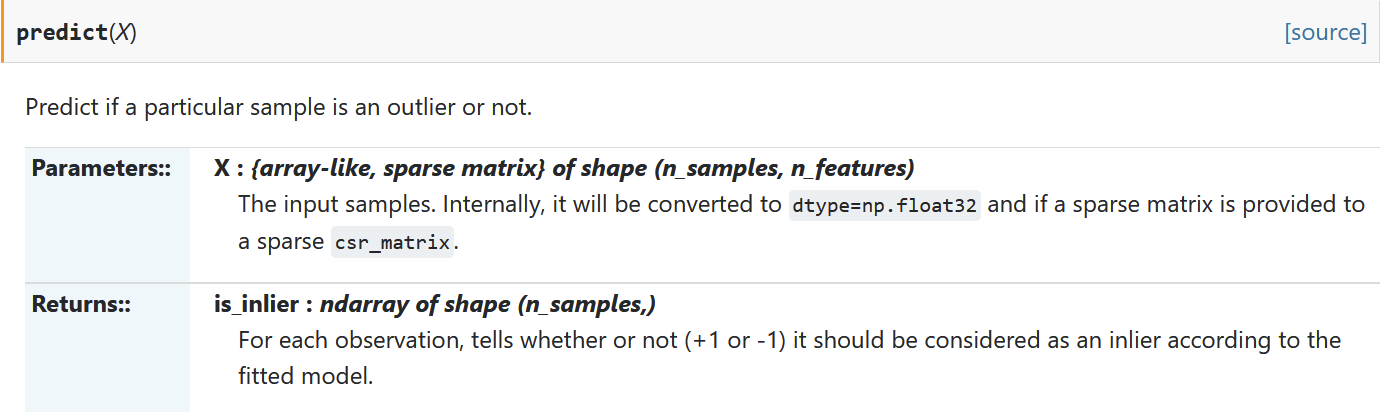

### Using Isolation Forest to Detect and Remove Outliers from the Data

In [40]:
# Automatic method to detect the Outliers : Isolation Forest
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators=200, contamination='auto')
iforest = iforest.fit(X_train) #Training the model

### Predictions after applying 
Predict tells us whether a particular sample is Outlier or not

In [41]:
#Predictions after applying 
# Predict tells us whether a particular sample is Outlier or not
X_train_predict = iforest.predict(X_train) 
X_train['Predict']=X_train_predict

### Converting Predictions to Categorical Datatype

In [36]:
X_train['Predict'] = X_train['Predict'].astype('category') # Converting it to Categorical datatype
X_train

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Predict
Depth,,,,,,,,
2867.0,0.014620,1.188256,-0.077670,-0.853933,-0.071817,0.0,-1.172566,1
2845.5,-0.954401,-0.680484,-0.990291,0.022472,0.709467,0.0,0.050885,1
2962.0,0.290008,-1.219344,1.106796,0.726592,-0.138194,0.0,0.227876,1
2825.0,0.436158,-0.117444,1.417476,0.247191,-0.225245,-1.0,-0.787611,1
2935.5,-0.942362,0.006908,-0.213592,-0.292135,0.672470,0.0,-0.345133,1
...,...,...,...,...,...,...,...,...
2933.5,-0.979979,0.355786,-0.679612,0.007491,1.174102,0.0,0.539823,1
2904.0,0.191960,0.245250,0.504854,0.719101,-0.143634,-1.0,-0.181416,1
2843.5,-0.739443,0.797927,-0.446602,-0.546816,0.682263,0.0,0.168142,1


### Checking the pairplot to see the outliers differentiated by Isolation Forest

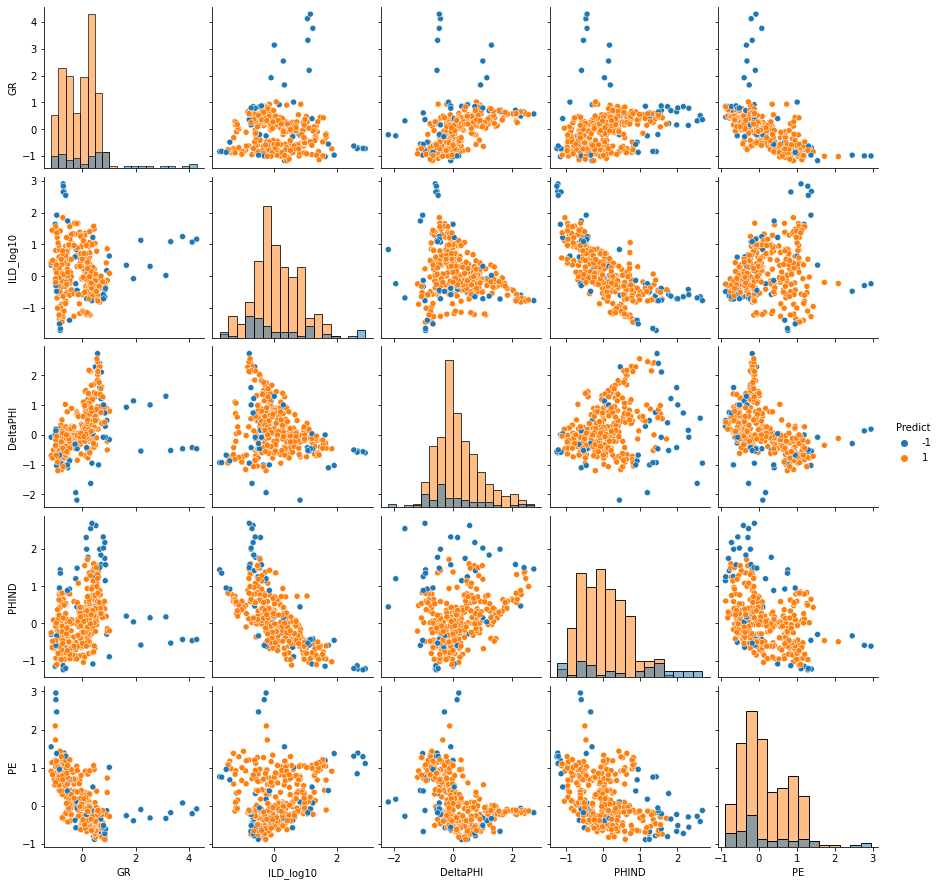

In [37]:
sns.pairplot(X_train.drop(['NM_M','RELPOS'],axis=1),hue='Predict',diag_kind='hist')

### Removing outliers by only keeping the data with the Isolation Forest response feature as 1

In [38]:
# We can remove the outliers from the data to avoid getting a biased model 
X_train['y_train']=y_train
X_train = X_train[X_train['Predict'] == 1] # Hence removing the outliers that predicted -1

### Separating Training and Testing Data

In [39]:
y_train=X_train['y_train']
X_train = X_train.drop(['Predict','y_train'], axis = 1)

### Training Data

In [40]:
X_train

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Depth,,,,,,,
2867.0,0.014620,1.188256,-0.077670,-0.853933,-0.071817,0.0,-1.172566
2845.5,-0.954401,-0.680484,-0.990291,0.022472,0.709467,0.0,0.050885
2962.0,0.290008,-1.219344,1.106796,0.726592,-0.138194,0.0,0.227876
2825.0,0.436158,-0.117444,1.417476,0.247191,-0.225245,-1.0,-0.787611
2935.5,-0.942362,0.006908,-0.213592,-0.292135,0.672470,0.0,-0.345133
...,...,...,...,...,...,...,...
2983.0,0.581044,-0.777202,2.135922,0.808989,-0.118607,-1.0,0.055310
2933.5,-0.979979,0.355786,-0.679612,0.007491,1.174102,0.0,0.539823
2904.0,0.191960,0.245250,0.504854,0.719101,-0.143634,-1.0,-0.181416


### Training Response Feature

In [41]:
y_train

Depth
2867.0    8
2845.5    6
2962.0    7
2825.0    2
2935.5    8
         ..
2983.0    3
2933.5    8
2904.0    2
2843.5    8
2851.5    5
Name: y_train, Length: 324, dtype: int64

### Checking the pairplot to see the outliers removed by Isolation Forest

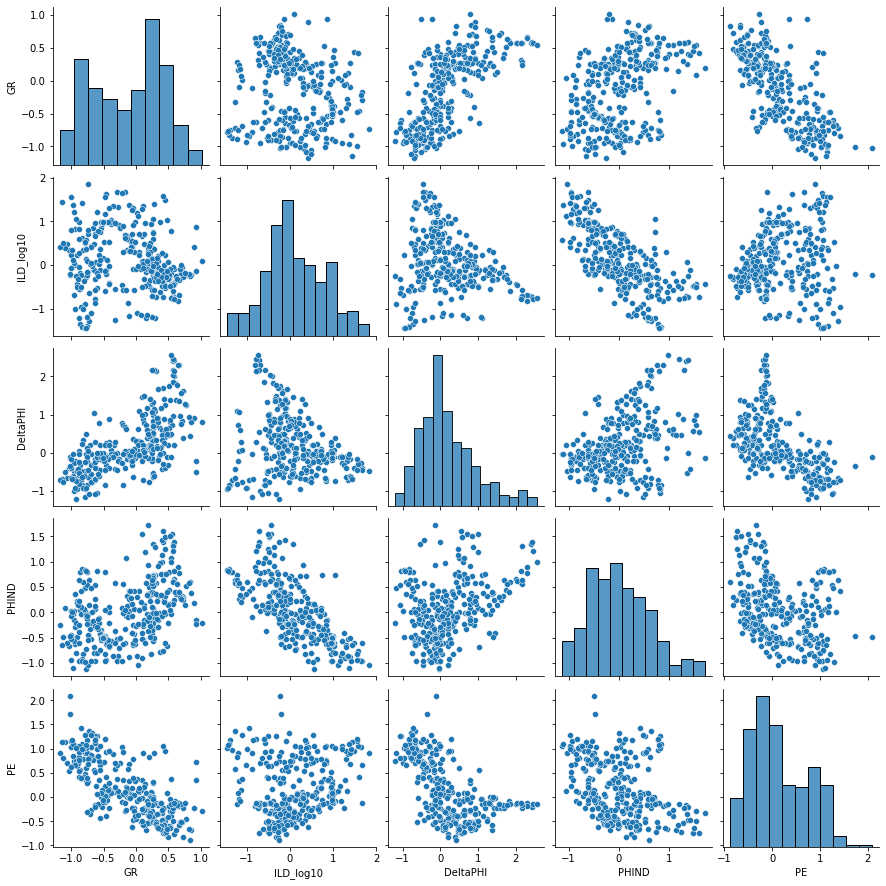

In [42]:
sns.pairplot(X_train.drop(['NM_M','RELPOS'],axis=1),diag_kind='hist') # After removal of outliers

### Applying KNN Model to the Data

Looping over k from 1 to 20 to classify the facies which is the response.
Also looking at both Manhattan and Euclidean distance to see which model gives us the better score

#### K Nearest Neighbours

Machine learning method for supervised learning for classification and regression analysis.  Here are some key aspects of $k$ nearest neighbours.

**Prediction**

* non-parametric method for regression and classification

* a function $\hat{f}$ of the nearest $k$ training data in predictor feature space such that we predict a response feature $Y$ from a set of predictor features $X_1,\ldots,X_m$. 

* the prediction is of the form $\hat{Y} = \hat{f}(X_1,\ldots,X_m)$ 

* for classification the majority response category among the $k$ nearest training data is selected as the prediction

* for regression the average (or other weighted average, like inverse distance weighted) of the response features among the $k$ nearest training data is assigned as the prediction 

**Supervised Learning**

* the response feature label, $Y$, is available over the training and testing data

**Instance-based Learning / Lazy Learning**

* the prediction function is approximated locally and calculation is defered until a prediction is needed

* there is no compact 'model'.  The model is the training data and the hyperparameters
    
**Hyperparameters**

* **$k$ number of nearest data** to utilize for prediction

* **data weighting**, for example uniform weighting (use local training data average), inverse distance weighting

Note, for the case of inverse distance weighting, the method is analogous to inverse distance weighted interpolation with a maximum number of local data constraint commonly applied for spatial interpolation.  Inverse distance is available in GeostatsPy for spatial mapping.

* **distance metric** - more below

**Distance Metric**

* training data within the predictor feature space are ranked by distance (closest to farthest)

* a variety of distance metrics may be applied, including:


1. euclidian distance 

\begin{equation}    
d_i = \sqrt{\sum_{\alpha = 1}^{m} \left(x_{\alpha,i} - x_{\alpha,0}\right)^2} 
\end{equation}

2. overlap metric / Hamming distance used for discrete variables
    
3. correlation coefficients used for comparing sets and images 

##### Why Cover k Nearest Neighbour Regression and Classification?

The method is simple and flexible

* very understandable, interpretable  

* accessible introduction to the concepts of tuning hyperparameters and overfit


The following explanation is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfaceDataAnalytics_KNN.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb).


In [46]:
# k =  1 creates a complex model that is prone to overfitting
# k= 20 creates simple model that has large bias
# p = 2 indicates euclidean distance, p = 1 indicates manhattan distance
from sklearn.neighbors import KNeighborsClassifier
p = [1, 2]
k = [1, 5, 10, 15, 20]
score = []
for i in p:
    for j in range(1,20):
        knn = KNeighborsClassifier(n_neighbors=j,p=i)
        knn.fit(X_train,y_train)
        gen = knn.score(X_test,y_test)
        mem = knn.score(X_train,y_train) #.score gives f1 for classifiers
        dif = abs(mem - gen)
        score.append([i,j,gen,mem,dif])

score = pd.DataFrame(score,columns=['p', 'k', 'Gen_Score', 'Mem_Score', 'Diff'])
#print(score)
#print('')

score = score[score.Gen_Score > score.Gen_Score.mean()]
n = score.index[score.Diff == score.Diff.min()]

Best_P = score.p[score.index == n[0]].values.tolist()
Best_K = score.k[score.index == n[0]].values.tolist()
Best_Gen_Score=score.Gen_Score[score.index == n[0]].values.tolist()
Best_Mem_Score=score.Mem_Score[score.index == n[0]].values.tolist()

knn = KNeighborsClassifier(n_neighbors=Best_K[0],p=Best_P[0])
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
gen1 = knn.score(X_test,y_test)
mem1 = knn.score(X_train,y_train) 

Model_2 = ['KNN',gen1,mem1,Best_P[0],Best_K[0]]

print('After tuning the Best p = {} and k = {}'.format(Best_P[0],Best_K[0]))
print('with a generalization Score of {} '.format(gen1))
print('with a memorization Score of {}'.format(mem1))

After tuning the Best p = 1 and k = 10
with a generalization Score of 0.7052631578947368 
with a memorization Score of 0.7561728395061729


### Fitting the best model to the data

In [47]:
knn = KNeighborsClassifier(n_neighbors=10, p=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, p=1)

### Calculating F1 score of the model

Computing the F1 score, also known as balanced F-score or F-measure.

The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)

In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter.

In [48]:
print('generalization         :',knn.score(X_test,y_test))   
print('memorization           :',knn.score(X_train,y_train)) 
print('F1_score_generalization  :',f1_score(y_test,knn.predict(X_test),average="weighted"))  
print('F1_score_memorization    :',f1_score(y_train,knn.predict(X_train),average="weighted")) 

generalization         : 0.7052631578947368
memorization           : 0.7561728395061729
F1_score_generalization  : 0.6904901314524924
F1_score_memorization    : 0.7405631460728289


### Loading the Test Well

In [49]:
test_well

,Formation,Well Name,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies,Facies_Label
Depth,,,,,,,,,,,
2972.5,A1 LM,CRAWFORD,49.675,0.845,3.905,11.175,3.265,2,1.000,6,WS
2973.0,A1 LM,CRAWFORD,34.435,0.879,3.085,8.175,3.831,2,0.991,8,PS
2973.5,A1 LM,CRAWFORD,26.178,0.920,2.615,4.945,4.306,2,0.981,8,PS
2974.0,A1 LM,CRAWFORD,19.463,0.967,0.820,3.820,4.578,2,0.972,8,PS
2974.5,A1 LM,CRAWFORD,19.260,0.995,0.320,3.630,4.643,2,0.962,8,PS
...,...,...,...,...,...,...,...,...,...,...,...
3158.5,C SH,CRAWFORD,86.078,0.554,5.040,16.150,3.161,1,0.639,3,FSiS
3159.0,C SH,CRAWFORD,88.855,0.539,5.560,16.750,3.118,1,0.611,3,FSiS
3159.5,C SH,CRAWFORD,90.490,0.530,6.360,16.780,3.168,1,0.583,3,FSiS


### Differentiating the Predictor and Response Features

In [50]:
X = test_well.drop(['Facies','Formation','Well Name','Facies_Label'], axis = 1) 
y_test = test_well['Facies'] 

X

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Depth,,,,,,,
2972.5,49.675,0.845,3.905,11.175,3.265,2,1.000
2973.0,34.435,0.879,3.085,8.175,3.831,2,0.991
2973.5,26.178,0.920,2.615,4.945,4.306,2,0.981
2974.0,19.463,0.967,0.820,3.820,4.578,2,0.972
2974.5,19.260,0.995,0.320,3.630,4.643,2,0.962
...,...,...,...,...,...,...,...
3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639
3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611
3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583


### Scaling the Testing Data

In [51]:
#Robust Scaler on our Testing Data
X_test = rs.transform(X)
X_test=pd.DataFrame(X_test,index=X.index, columns=X.columns)
X_test

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Depth,,,,,,,
2972.5,-0.203867,0.618307,0.292233,0.041199,-0.367791,0.0,0.982301
2973.0,-0.605332,0.735751,0.133010,-0.408240,0.248096,0.0,0.962389
2973.5,-0.822844,0.877375,0.041748,-0.892135,0.764962,0.0,0.940265
2974.0,-0.999737,1.039724,-0.306796,-1.060674,1.060936,0.0,0.920354
2974.5,-1.005084,1.136442,-0.403883,-1.089139,1.131665,0.0,0.898230
...,...,...,...,...,...,...,...
3158.5,0.755091,-0.386874,0.512621,0.786517,-0.480958,-1.0,0.183628
3159.0,0.828245,-0.438687,0.613592,0.876404,-0.527748,-1.0,0.121681
3159.5,0.871315,-0.469775,0.768932,0.880899,-0.473341,-1.0,0.059735


### Function to plot the well logs for the test well

In [52]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [53]:
test_well.reset_index(inplace = True)

### Applying the model to the Testing Data and predicting the Facies classification

In [54]:
y_pred=knn.predict(X_test)
test_well['Prediction'] = y_pred

### Plotting the Well logs along with the predicted facies besides the original facies

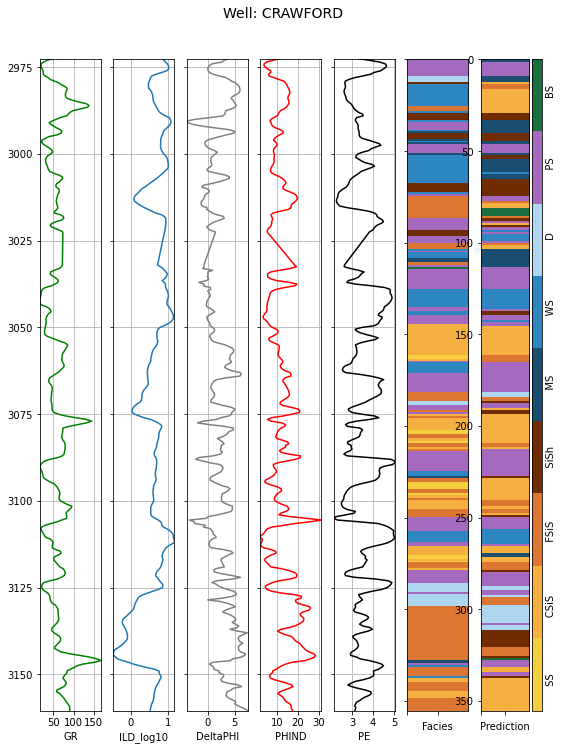

In [55]:
compare_facies_plot(test_well, 'Prediction', facies_colors)

### Testing Metrics for the model

In [57]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix
target_names = ['SS', 'CSiS', 'FSiS', 'SiSh','MS', 'WS', 'D','PS','BS']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          SS       0.00      0.00      0.00        13
        CSiS       0.43      0.86      0.58        49
        FSiS       0.53      0.19      0.28        90
        SiSh       0.29      0.75      0.42        16
          MS       0.14      0.56      0.22         9
          WS       0.65      0.26      0.37        66
           D       0.21      0.24      0.22        17
          PS       0.73      0.76      0.74        95
          BS       0.00      0.00      0.00         1

    accuracy                           0.47       356
   macro avg       0.33      0.40      0.31       356
weighted avg       0.54      0.47      0.45       356



### Creating the confusion matrix of the prediction

Compute confusion matrix to evaluate the accuracy of a classification.

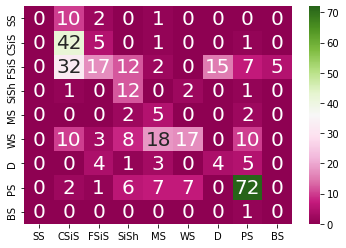

In [59]:
#Confusion Matrix to evaluate the accuracy of the Classification
cf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 20},cmap='PiYG',fmt="d",xticklabels=target_names,yticklabels=target_names)

plt.show()

###  Results and Discussions

* KNN was used for facies classification from the well-log responses as the predictor features.

* The KNN model was tuned over the hyperparameters p and k and the model with the best hyperparameters(p = 1 and k = 10)   was used to retrain the model on all data and then applied to the blind data. Even though our dataset had 9 facies, the best model was obtained using k = 10.

* F-1 score was used to evaluate the model performance on the training data.

* Confusion matrix was plotted to test the original facies along with the predicted facies for the blind dataset.

* The well log along with the original facies vs the predicted facies were also predicted to show the visualization of the prediction.


### References

* https://github.com/seg/tutorials-2016/blob/master/1610_Facies_classification/Facies%20Classification%20-%20SVM.ipynb

* Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, Computers & Geosciences, 33 (5), 599-617 pp. doi:10.1016/j.cageo.2006.08.011

* Facies classification using machine learning Hall, Brendon. https://doi.org/10.1190/tle35100906.1

* https://scikit-learn.org/stable/index.html


### Divya Shah, MS Petroleum Engineering, The University of Texas at Austin 

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
